# EasyVVUQ - Basic Concepts

**Author**: Vytautas Jancauskas, LRZ (jancauskas@lrz.de)

If this is your first Jupyter Notebook - you can execute code cells by selecting them and pressing ```Shift+Enter```. Just have in mind that the order of execution might matter (if later cells depend on things done in earlier ones).

The aim of EasyVVUQ is to facilitate verification, validation and uncertainty quantification (VVUQ) for a wide variety of simulations. While very convenient for simple cases, EasyVVUQ is particularly well suited in situations where the simulations are computationally expensive, heterogeneous computing resources are necessary, the sampling space is very large or book-keeping is prohibitively complex. It coordinates execution using an efficient database, it is fault tolerant and all progress can be saved.

Here are some examples of questions EasyVVUQ can answer about your code:

Given the uncertainties in input parameters, what is the distribution of the output?
What percentage of the output variance each input parameter contributes?
It also lets you construct surrogate models that are cheaper to evaluate than the complete simulation.

The high-level overview of the library is avalable at our [readthedocs.]()



This tutorial shows a simple EasyVVUQ workflow in action. The example used here is a simulation of a vertical deflection of a tube. The model is that of a round metal tube suspended on each end and force being applied at a certain point along it's length. The model measures how large is the deflection at the point force is applied. Full description of it can be found [here](https://openturns.github.io/openturns/latest/usecases/use_case_deflection_tube.html). This model was chosen since it is intuitively easy to understand even without any background in the relative field. It is also easy to interpret the results. We will use EasyVVUQ to determine the influence each of the input parameters has on the vertical deflection at point ```a```.

The usage of the application is:

```beam <input_file>```

It outputs a single file called output.json, which will look like ```{'g1': x, 'g2': y, 'g3': y}``` where ```g1``` is the vertical displacement at point ```a``` and ```g2```, ```g3``` are displaced angles of the tube at the left and right ends respectively.

The beam.template is a template input file, in JSON format

```{"outfile": "$outfile", "F": $F, "L": $L, "a": $a, "D": $D, "d": $d, "E": $E}```

The values for each key are tags (signified by the $ delimiter) which will be substituted by EasyVVUQ with values to sample the parameter space. In the following tutorial, the template will be used to generate files called input.json that will be the input to each run of ```beam```.

So, for example (commands preceded by an exclamation mark are treated as shell commands):

In [18]:
!echo '{"outfile": "output.json", "F": 1.0, "L": 1.5, "a": 1.0, "D": 0.8, "d": 0.1, "E": 200000}' > input.json

In [19]:
!./beam input.json

In [20]:
!cat output.json

{"g1": -6.909453505549654e-06, "g2": -1.3818907011099308e-05, "g3": 1.7273633763874136e-05}

In this tutorial we will see how to use EasyVVUQ to do variance based sensitivity analysis using Polynomial Chaos Expansion (PCE). It is one of several methods that EasyVVUQ supports for this purpose (others being Monte Carlo and Stochastic Collocation methods). While PCE supports more complicated scenarios we only explore the basic functionality. Of course the users are not limited to the methods provided by default in EasyVVUQ and can easily implement their own sampling and analysis classes.

# Campaign

We need to import EasyVVUQ as well as ChaosPy (we use it's distributions) and matplotlib for plotting later on.

In [21]:
import os
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, CleanUp, ExecuteLocal, Actions

We will describe the parameters. This is done for validation purposes (so that input parameters outside valid ranges given an error. Also this is where you can specify default values for input parameters that you don't want to vary in the analysis. Only the type and the default value fields are mandatory.

In [22]:
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

Next step is to specify how the input files for the simulation are to be created and how EasyVVUQ is to parse the output of the simulation. This is the job of the Encoder and Decoder classes. Our simulation takes a very simple JSON file as input. So we can just use the GenericEncoder which is a template based encoder. It will replace all keys in the template file with respective values. In this case they are identified by the ```$``` that precedes them. Alternatively, there are more complex encoders based on, for example, the [Jinja2](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.jinja_encoder) templating language. Encoders can also do more complicated things, such as prepare a [directory structure](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.directory_builder) if your simulation requires such. If it requires several input files you can use a [multiencoder](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.multiencoder) to combine several encoders, each of which responsible for a single input file. They can also be used to [copy](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.copy_encoder) files over to the run directory.

Decoder is responsible for parsing the otuput of the simulation. We use the [JSONDecoder](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.json) to extract the needed value. There also exist ready made decoders for [YAML](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.yaml) and [CSV](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.simple_csv). You can also easily write your own by inheriting from the BaseDecoder class.

In [23]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])
execute = ExecuteLocal('{}/beam input.json'.format(os.getcwd()))

actions = Actions(CreateRunDirectory('/tmp'), 
                  Encode(encoder), execute, Decode(decoder))

Campaign is the central hub in which operations take place. It is responsible for running your simulations, gathering the results, storing them in the Database, retrieving them for analysis, etc. The Campaign in EasyVVUQ is very powerful and supports multiple applications, sampling, analysis and execution methods. It also lets you save progress and retrieve results later for analysis. Here we only look at a simple case.

In [24]:
campaign = uq.Campaign(name='beam', params=params, actions=actions)

First we need to define the input parameter distributions. We have chosen 4 of the 6 available inputs. This is partly because this means that we won't have to sample at too many points and partly because I've found that these influence the output variable the most.

In [25]:
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    #"a": cp.Uniform(0.7, 1.2),
    #"D": cp.Triangle(0.75, 0.8, 0.85)
}

We have to choose the sampler next. For this task we can use either [Stochastic Collocation](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.stochastic_collocation), [Polynomial Chaos Expansion](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.pce) or [QMC](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.qmc) samplers. Stochastic Collocation is fast for this problem size so that is what we chose.

In [26]:
campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=3))

For this tutorial we have chosen to run the simulation on the local machine. This will done in parallel with up to 8 tasks running concurrently. Alternatives are execution in the Cloud (via the [ExecuteKubernetes](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.actions.html#module-easyvvuq.actions.execute_kubernetes) action) or on HPC machines.

In [27]:
campaign.execute().collate()

The execution can take a bit since we need to generate several hundred samples. We asked it to evaluate 8 samples in parallel. You can track progress by using the ```progress``` method. You can also check progress automatically and resume execution after it is done if you want to run this inside a script rather than interactively.

In [28]:
campaign.get_collation_result()

,run_id,iteration,F,L,a,D,d,E,outfile,g1
,0,0,0,0,0,0,0,0,0,0
0,1,0,0.766559,1.476656,1.0,0.8,0.1,200000,output.json,-0.000005
1,2,0,0.766559,1.492580,1.0,0.8,0.1,200000,output.json,-0.000005
2,3,0,0.766559,1.507420,1.0,0.8,0.1,200000,output.json,-0.000005
3,4,0,0.766559,1.523344,1.0,0.8,0.1,200000,output.json,-0.000006
4,5,0,0.925804,1.476656,1.0,0.8,0.1,200000,output.json,-0.000006
5,6,0,0.925804,1.492580,1.0,0.8,0.1,200000,output.json,-0.000006
6,7,0,0.925804,1.507420,1.0,0.8,0.1,200000,output.json,-0.000007
7,8,0,0.925804,1.523344,1.0,0.8,0.1,200000,output.json,-0.000007
8,9,0,1.074196,1.476656,1.0,0.8,0.1,200000,output.json,-0.000007


We then call the analyse method whose functionality will depend on the sampling method used. It returns an [AnalysisResults]() object which can be used to retrieve numerical values or plot the results. In this case Sobols indices.

In [29]:
results = campaign.analyse(qoi_cols=['g1'])

We can plot the results in a treemap format. Each square representing the relative influence of that parameter to the variance of the output variable (vertical displacement at point ```a```). A square labeled ```higher orders``` represent the influence of the interactions between the input parameters.

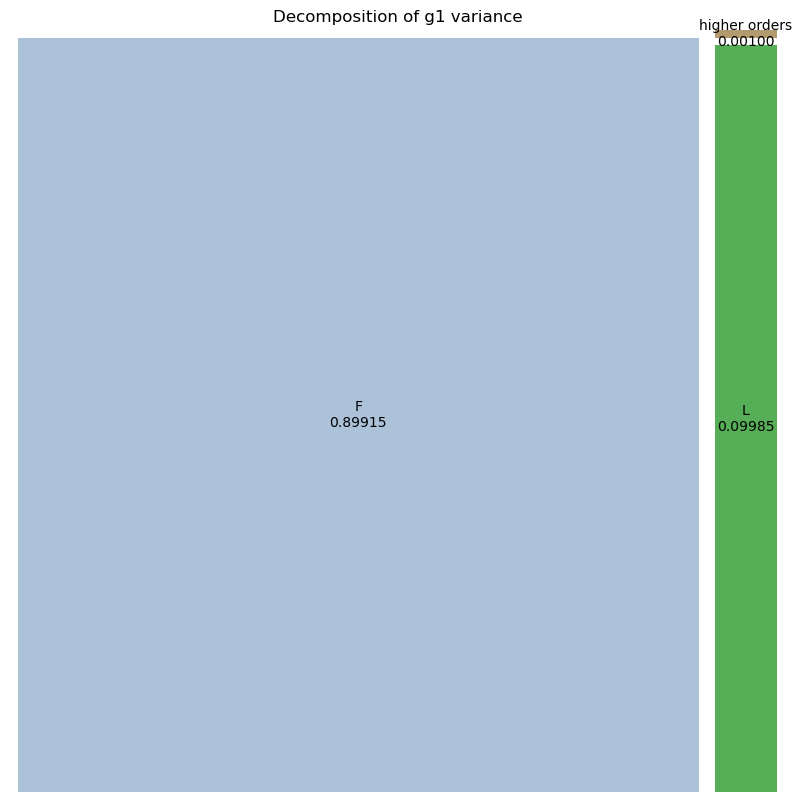

In [30]:
results.plot_sobols_treemap('g1', figsize=(10, 10))
plt.axis('off');

Alternatively you can get the Sobol index values using the method call below.

In [31]:
results.sobols_first('g1')

{'F': array([0.89914734]), 'L': array([0.09985412])}

In [32]:
results.supported_stats()

['min', 'max', '10%', '90%', '1%', '99%', 'median', 'mean', 'var', 'std']

In [33]:
results._get_sobols_first('g1', 'F')

array([0.89914734])

In [34]:
results.sobols_total('g1', 'F')

array([0.90014588])